In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pynoisy
import xarray as xr
import time, os
from tqdm.notebook import tqdm
import metric_utils

## Load eigenvectors
---

In [2]:
path = '../../scripts/clouds/eigenvectors/windmag_deg24_wind_angle5.48_LOBPCG_maxiter30_rawgrf_changemeas.nc'
info = xr.load_dataarray(path)
info

<xarray.DataArray (wind_magnitude: 40)>
array([ 1.        ,  2.25641026,  3.51282051,  4.76923077,  6.02564103,
        7.28205128,  8.53846154,  9.79487179, 11.05128205, 12.30769231,
       13.56410256, 14.82051282, 16.07692308, 17.33333333, 18.58974359,
       19.84615385, 21.1025641 , 22.35897436, 23.61538462, 24.87179487,
       26.12820513, 27.38461538, 28.64102564, 29.8974359 , 31.15384615,
       32.41025641, 33.66666667, 34.92307692, 36.17948718, 37.43589744,
       38.69230769, 39.94871795, 41.20512821, 42.46153846, 43.71794872,
       44.97435897, 46.23076923, 47.48717949, 48.74358974, 50.        ])
Dimensions without coordinates: wind_magnitude
Attributes:
    runname:          wind_magnitude_modes
    desc:             LOBPCG eigenvectors for different homogeneous wind magn...
    date:             05-Nov-2020-21:55:01
    num_magnitudes:   40
    min_magnitude:    1
    max_magnitude:    50
    lobpcg_iter:      30
    preconditioning:  True

In [3]:
eigenvectors = [xr.load_dataarray(path, group='mode{}'.format(i)) for i in range(info.num_magnitudes)]

## Metric comparison
---

In [82]:
wind_magnitude_range = [info.min_magnitude, info.max_magnitude]
wind_magnitude_true = pynoisy.utils.uniform_sample(*wind_magnitude_range)
wind_magnitude_true = 24.6

hyperparams = {
    'nt': eigenvectors[0].nt.data,
    'nx': eigenvectors[0].nx.data,
    'ny': eigenvectors[0].ny.data,
    'wind_angle': eigenvectors[0].wind_angle.data,
    'wind_magnitude': wind_magnitude_true,
    'correlation_time': eigenvectors[0].correlation_time.data,
    'correlation_length': eigenvectors[0].correlation_length.data,
    'evolution_length': eigenvectors[0].evolution_length.data,
    'spatial_angle': eigenvectors[0].spatial_angle.data,
    'tensor_ratio': eigenvectors[0].tensor_ratio.data}
solver = pynoisy.forward.HGRFSolver.homogeneous(**hyperparams)
humidity = solver.run(num_frames=hyperparams['nt'], n_jobs=4, evolution_length=hyperparams['evolution_length'])

<IPython.core.display.Javascript object>


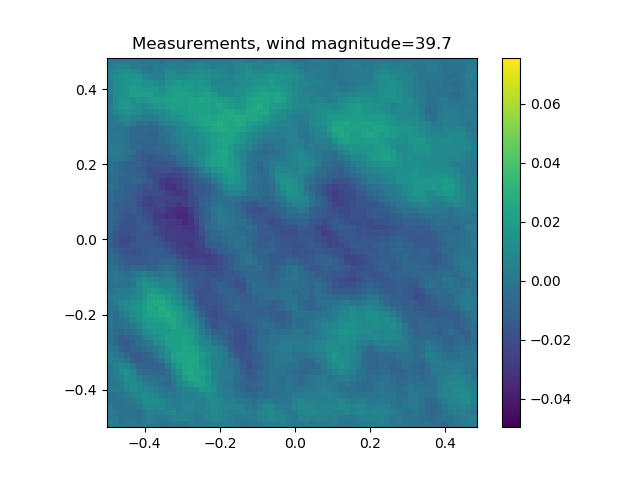

In [5]:
%matplotlib notebook
animation = humidity.noisy_methods.get_animation(cmap='viridis')
plt.title('Measurements, wind magnitude={:1.3}'.format(wind_magnitude_true))
animation.save('tmp.gif', writer='imagemagick')

In [83]:
"""
Compute likelihood metrics for eigenvector projection
"""
measurements = humidity
degrees = [1, 4, 8, 16, 24]    # number of eigenmodes
metrics = xr.merge([metric_utils.likelihood_metrics(measurements, eigenvectors, deg) for deg in degrees])

In [84]:
"""
Compute the full Rayleigh quotient for the full rank matrix
"""
coords = {info.dims[0]: info.data}
full_quotient = metric_utils.compute_full_quotient(humidity, hyperparams, coords)
full_quotient = xr.DataArray(full_quotient, dims=info.dims, coords=coords, name='full_quotient')
metrics = xr.merge([metrics, full_quotient])

Setting solver seed to: 13576

In [85]:
krylov_residual = metric_utils.compute_krylov_loss(measurements, hyperparams, coords, degrees)
metrics = xr.merge([metrics, krylov_residual])

Setting solver seed to: 17128


<IPython.core.display.Javascript object>


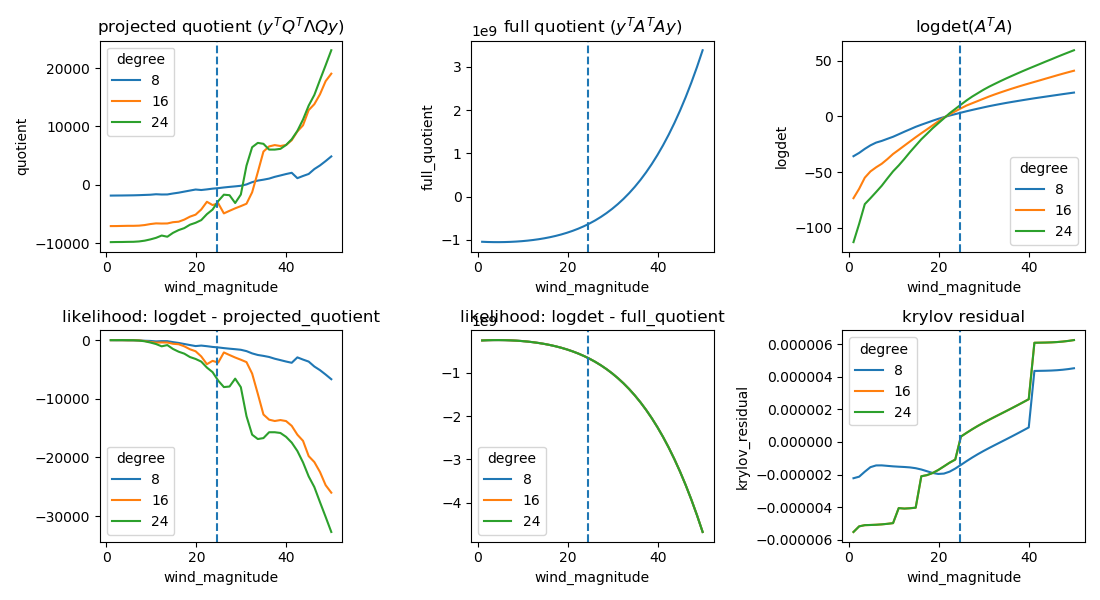

In [86]:
%matplotlib notebook

degrees = [8, 16, 24]
metrics_reduced = metrics.sel(degree=degrees)

fig, ax = plt.subplots(2, 3, figsize=(11,6))
(metrics_reduced.quotient - metrics_reduced.quotient.mean(info.dims[0])).plot.line(ax=ax[0,0], hue='degree')
ax[0,0].set_title(r'projected quotient ($y^TQ^T \Lambda Q y$)')
ax[0,0].axvline(wind_magnitude_true, linestyle='--')

(metrics_reduced.full_quotient - metrics_reduced.full_quotient.mean(info.dims[0])).plot.line(ax=ax[0,1])
ax[0,1].set_title(r'full quotient ($y^TA^T A y$)')
ax[0,1].axvline(wind_magnitude_true, linestyle='--')


(metrics_reduced.logdet - metrics_reduced.logdet.mean(info.dims[0])).plot.line(ax=ax[0,2], hue='degree')
ax[0,2].set_title(r'$\log \det (A^TA)$')
ax[0,2].axvline(wind_magnitude_true, linestyle='--')

(metrics_reduced.logdet - metrics_reduced.quotient).plot.line(ax=ax[1,0], hue='degree')
ax[1,0].set_title('likelihood: logdet - projected_quotient')
ax[1,0].axvline(wind_magnitude_true, linestyle='--')


(metrics_reduced.logdet - metrics_reduced.full_quotient).plot.line(ax=ax[1,1], hue='degree')
ax[1,1].set_title('likelihood: logdet - full_quotient')
ax[1,1].axvline(wind_magnitude_true, linestyle='--')


(metrics_reduced.krylov_residual - metrics_reduced.krylov_residual.mean(info.dims[0])).plot.line(ax=ax[1,2], hue='degree')
ax[1,2].set_title('krylov residual')
ax[1,2].axvline(wind_magnitude_true, linestyle='--')

plt.tight_layout()


<IPython.core.display.Javascript object>


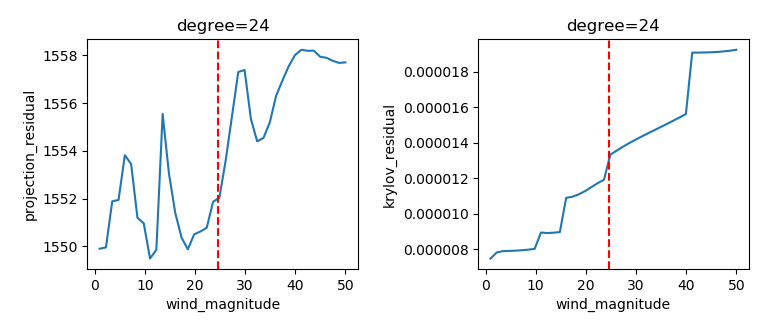

In [88]:
%matplotlib notebook

degree = 24
fig, ax = plt.subplots(1, 2, figsize=(7,3))
metrics.projection_residual.sel(degree=degree).plot(ax=ax[0])
ax[0].axvline(wind_magnitude_true, color='r', linestyle='--')
ax[0].set_title('degree={}'.format(degree))

metrics.krylov_residual.sel(degree=degree).plot(ax=ax[1])
ax[1].axvline(wind_magnitude_true, color='r', linestyle='--')
ax[1].set_title('degree={}'.format(degree))
plt.tight_layout()

<IPython.core.display.Javascript object>


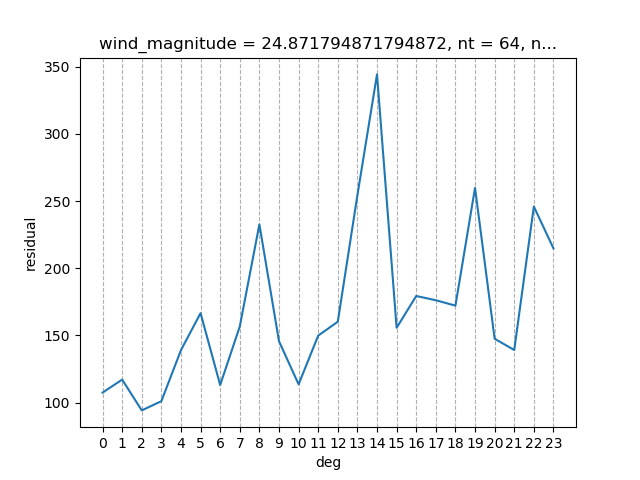

In [91]:
%matplotlib notebook
index = 19
modes = eigenvectors[index].squeeze('wind_magnitude')
modes.residual.plot()
plt.xticks(range(24));
plt.grid(linestyle='--', axis='x')

<IPython.core.display.Javascript object>


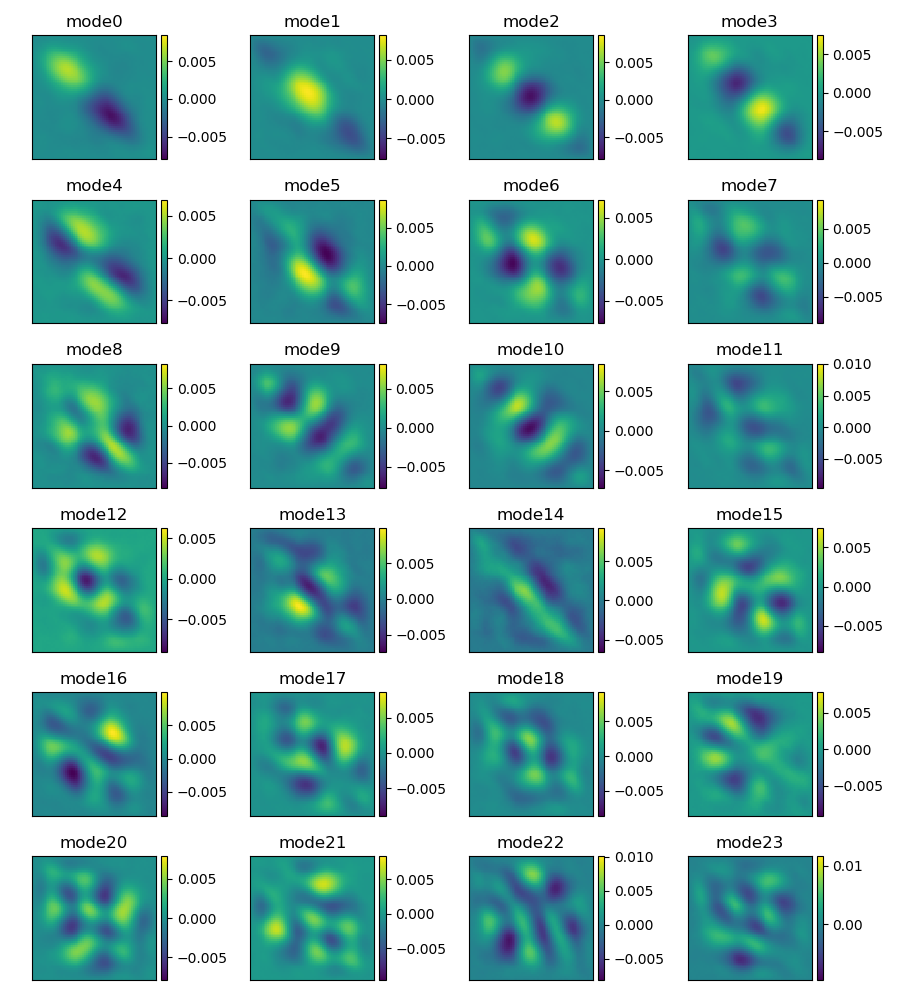

In [92]:
%matplotlib notebook
animation_degree = 24
fig, axes = plt.subplots(int(animation_degree/4),4, figsize=(9,10))
animation = pynoisy.utils.multiple_animations(
    modes.sel(deg=range(animation_degree)), axes.ravel(), cmaps='viridis', 
    titles=['mode{}'.format(deg, modes.wind_magnitude.data) for deg in range(animation_degree)])

In [94]:
animation.save('tmp.gif', writer='imagemagick')